In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import funciones as f

from scipy.spatial.transform import Rotation as rot
from scipy.optimize import minimize

# New approach

## The spherical coordinate system

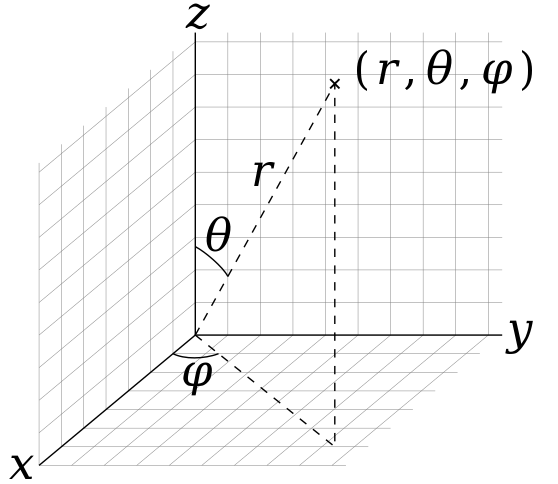

Spherical coordinates $(r, \theta, \varphi)$ as used in physics (ISO 80000-2:2019), being $r$ the radial distance (distance to origin), polar angle $\theta$ (theta) (angle with respect to polar/zenith z-axis), and azimuthal angle $\varphi$ or $\phi$ (phi) (angle of rotation from the initial meridian plane).

> **Important note**: the angles $\theta$ and $\varphi$/$\phi$ in Asimov et al. (2006) are interchanged with respect to the convention used in physics (see https://en.wikipedia.org/wiki/Spherical_coordinate_system). To avoid confusion, perhaps it would be a good idea to rename them (alpha and beta?) since strictly speaking they are angles with respect to crystallographic axes, not to the reference system (although later we will make them coincide).

## Set the FTIR reference frame

To estimate the orientation of the crystals in the FTIR we will have to consider the following reference frames to establish a consistent coordinate frame:

- the microscope stage/sample pair
- the position of the reference transmittance envelope with respect to the reference system of the microscope
- the position of the crystal elements (axes, planes, etc.) with respect to the transmitance envelope

We start by defining that all coordinate systems used will be right handed, which also implies the right hand rule for the sense of rotations (positive rotation counter-clockwise). To determine the full orientation of a crystal, it is necessary to define a Cartesian reference frame for the crystal lattice. The unit cell is commonly described using three lengths, $a$, $b$ and $c$ and three angles $α$, $β$, $γ$ as depicted in the figure below. For a general case:

- $a$, $b$ and $c$ form a right handed set.
- $c$ is parallel always to the $z$ axis.
- $b$ lies in the $y$-$z$ plane, at an angle $α$ to $c$
- $a$ is pointed such that it is an angle $β$ to $c$ and $γ$ to $b$

![EBSD_ref_frame](https://raw.githubusercontent.com/bertopadron/FTIR-EBSD/main/notebooks2learn/imgs/EBSD_unit_cell_convention.png)

As olivine is orthorhombic, the axes defining the olivine unit cell are perpendicular to each other and thus the $c$-axis is parallel to $z$, the $a$-axis is parallel to $x$, and the $b$-axis is parallel to $y$. With this reference frame, the transmittance figure in our coordinate system is as follows:

TODO → ADD FIGURE


In [2]:
# check that a phi (azimuth) angle of 0 and a theta of 90 is the coordinates (1,0,0)
f.sph2cart(1, azimuth=0)

(1.0, 0.0, 0.0)

In [3]:
# check that a phi (azimuth) angle of 90 and a theta (polar) of 90 is the coordinates (0,1,0)
f.sph2cart(1, azimuth=np.deg2rad(90), polar=np.deg2rad(90))

(0.0, 1.0, 0.0)

In [4]:
# check that for a theta (polar) angle of 0, whatever the phi (azimuth) angle, the coordinate is (0,0,1)
for angle in range(0, 90, 20):
    print(f'azimuth = {angle}, {f.sph2cart(1, azimuth=np.deg2rad(angle), polar=0)}')

azimuth = 0, (0.0, 0.0, 1.0)
azimuth = 20, (0.0, 0.0, 1.0)
azimuth = 40, (0.0, 0.0, 1.0)
azimuth = 60, (0.0, 0.0, 1.0)
azimuth = 80, (0.0, 0.0, 1.0)


### Reference transmittance envelope

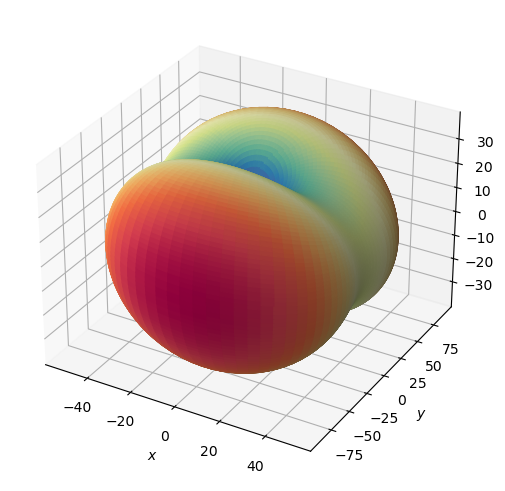

In [5]:
# generate a mesh of spherical/polar coordinates
polar, azimuths = f.regular_S2_grid(n_squared=100)

# estimate T values
T = f.Tvalues(trans=(90, 50, 20), azimuth=azimuths, polar=polar)

# convert from spherical to cartesian coordinates
x, y, z = f.sph2cart(T, azimuths, polar)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')


This would be the reference transmittance envelope for olivine for a given thickness and wavelength. Note that the maximum value (90), corresponding to $T_a$, alings with the $x$ direction in Cartesian space, and the minimum value (20), corresponding to $T_c$, alings with $z$ direction, as established in the previous figure.

> **Note.** Oddly, I had to swap $Ta$ and $Tb$ with respect to Asimov's equation so that $Ta$ aligns with the x-axis when transformed into Cartesian coordinates. See ``Tvalues`` function.

So we now have our olivine positioned with crystallographic a-axis a aligned with the x axis, crystallographic b-axis aligned with the y axis and crystallographic c-axis aligned with the z axis. Given these premises, the approach to determine the crystallographic orientation from a few transmittance measurements is as follows.

### Step 1. Make measurements

Estimate the transmission values on the microscope at different angles respect to the polarization direction. If the polariser is aligned with the x-axis and measurements are taken in the xy-plane, it would be:

$$
(T, azimuth, polar)
$$

where $T$ is the transmission measured, _azimuth_ is the angle in degrees between the polarizer (E-vector) and a reference within the sample (for example the large side of the sample or whatever suits us), and _polar_ is the polar angle that in this case is a constant (90 degrees). In practice we will measure for example:

$$
(T_1, 0), (T_2, 20), (T3, 30), ... , (T_n, 0≥angle<180)
$$

If we need to convert these values into Cartesian coordinates, we use the function ``sph2cart()``, for example:

In [6]:
# sph2cart convert from spherical/polar (magnitude, azimuth, polar) to cartesian coordinates.
# If the polar angle is not given, the coordinate is assumed to lie on the XY plane.
print(f'for T=35 and azimuth=45, the coordinates are: {f.sph2cart(35, azimuth=np.deg2rad(45))}')
print(f'for T=60 and azimuth=90, the coordinates are: {f.sph2cart(60, azimuth=np.deg2rad(90))}')

for T=35 and azimuth=45, the coordinates are: (24.748737, 24.748737, 0.0)
for T=60 and azimuth=90, the coordinates are: (0.0, 60.0, 0.0)


### Step 2. Check if measurements lie on the surface of the reference envelope.

According to Asimov et al. (2006), we can estimate $T$ for any direction using the simplified transmission equation as a function of $\theta$, $\phi$:

$$
T = T_a \cdot cos^2\phi sin^2\theta + T_b \cdot sin^2\phi sin^2\theta + T_c \cdot cos^2\theta
$$

> remember that in our reference system $\phi$ is the **polar angle** and $\theta$ the **azimuth angle**

as we know the $T_a, T_b, T_c$ values and we know $\theta$, and $\phi$ from our measures, we need to ensure that

$$
(T_{measured} - T_{theoretical})^2 = 0
$$

is fulfilled for all the measures taken.

### Step 3. Inverse calculation

If this equality above is not satisfied (within a reasonable tolerance), we need to convert these measurements to Cartesian coordinates (i.e. points), rotate these points (e.g. using Euler angles), convert back to spherical coordinates and check again. This process should be repeated until the solution converges. The rotation required to fulfil this condition is the orientation of the olivine crystal with respect to the established reference system.

### Pseudocode:

- Apply Step 2
- If solution converge: no rotation is nedeed and the olivine crystal is aligned as in the reference frame (e.g. Euler angle=(0,0,0))
- Else:
    - convert measures to cartesian coordinates
    - apply rotation using Eules angles (Bunge convention)
    - convert bak to spherical coordinates
    - check and continue until solution converges
    - return the Euler angles that orientate the olivine crystal

## Design the minimization procedure

TODO

In [7]:
# starting points, points are: (T, azimuth)
point_a = (np.deg2rad(0), 50)
point_b = (np.deg2rad(45), 45)
point_c = (np.deg2rad(90), 60)

not checked yet! **OLD implementation, to re-implement**

In [8]:
def check_points_on_surface(points, trans, tol=1e-6):
    """
    Given a set of points in 3D space, determine if they fall on the surface
    defined by the function T. If the points do not fall on the surface,
    apply a rotation to the points and check again until the points fall on
    the surface. Return the Euler angles that rotate the points to the surface.

    Parameters
    ----------
    points : tuple of size 3
        a tuple containing the cartesian coordinates of the points
        in the form (x, y, z). Each element can be a scalar or an array.
    trans : tuple of size 3
        tuple containing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    tol : float
        tolerance for determining if a point is on the surface

    Returns
    -------
    tuple of size 3
        tuple containing the Euler angles in degrees for rotating
        the points to the surface

    """
    def func(euler_ang, points, trans):
        """Returns the square of the difference between the values of T at the
        given points and the expected value of T for the given transmission values
        and angles of rotation."""
        rotated_points = f.rotate(points, euler_ang)
        T_values = T(trans, rotated_points[2], np.arctan2(rotated_points[1], rotated_points[0]))
        return np.sum((T_values - 1)**2)
    
    bounds = [(0, 90), (0, 180), (0, 90)]
    euler_ang_guess = (0, 0, 0)
    result = minimize(fun=func, args=(points, trans), x0=euler_ang_guess, bounds=bounds)
    euler_angles = result.x
    while result.fun > tol:
        points = f.rotate(points, euler_angles)
        result = minimize(fun=func, args=(points, trans), x0=euler_ang_guess, bounds=bounds)
        euler_angles = result.x
    return tuple(euler_angles)

## How to generate toy measures to test the procedure

1. Generate a dataset of euler angles
2. Estimate values on the XY plane using the ``extract_XY_section_fast()`` function for each orientation
3. Pick ten values for each section and store
4. Use this dataset to test the implementation above

we should obtain a dataframe like this:

| euler1 | euler 2 | euler3 |  T1  | Azi1 |  T2  | Azi2 |  T3  | Azi3 |
| :----: | :-----: | :----: | :--: | :--: | :--: | :--: | :--: | :--: |
|   0    |    0    |   0    | 50.0 |  0   | 85.7 |  36  | 65.3 |  72  |
|   30   |   30    |   0    | 47.7 |  0   | 69.0 |  36  | 72.7 |  72  |
|   0    |   30    |   60   | 50.0 |  0   | 62.3 |  36  | 68.6 |  72  |
|   60   |   60    |   60   | 29.2 |  0   | 50.7 |  36  | 79.3 |  72  |

where the first three columns are the euler angles (a.k.a. the solution), and the rest are transmission and azimuth angles respect to the polarizer (measures).


In [15]:
# STEP 1
euler_angles = f.explore_Euler_space(step=6)
euler_angles.shape

(7936, 3)

In [ ]:
# STEP 2

# STEP 2.1
# generate a mesh of spherical/polar coordinates
polar, azimuths = f.regular_S2_grid(n_squared=100)
# estimate T values
T = f.Tvalues(trans=(90, 50, 20), azimuth=azimuths, polar=polar)
# convert from spherical to cartesian coordinates
x, y, z = f.sph2cart(T, azimuths, polar)

# STEP 2.2
for angles in euler_angles:
    # rotate
    x2, y2, z2 = f.rotate(coordinates=(x, y, z), euler_ang=angles)
    # extract XY intersection
    xy_vectors = f.extract_XY_section_fast(x2, y2, z2)
    # estimate T and azimuths (cart2sph)
    # TODO